### Previously...

We learned (lots of) new concepts about images and how they can be loaded and manipulated in Python:

* Load & saving images using Pillow (PIL)
* Convert from PIL object to raw array data using numpy
* Display color images and their individual channels
* Plotting an intensity histogram
* Applying a threshold to produce binary image
* Morphological processing of binary images
* Calculating the center of mass

### Today

* Introduction to supervised / unsupervised learning
* The classification problem
* Train a random forest on the Pima Indians Diabetes Dataset

# Tutorial 2: Introduction to ML in Python

> "A computer program is said to learn from experience E with respect to some class of tasks T and performance measure P, if its performance at tasks in T, as measured by P, improves with experience E." 

*-- Tom Mitchell*

I personally prefer to think of machine learning as an extension of statistics, in which we aim to identify patterns in data in order to make predictions. Broadly speaking, there are two flavours of ML:

![ML](https://cdn-images-1.medium.com/max/1600/1*6mPnd6tEA4EsYD1f72hGkA.png)

For the time being, we are going to focus on **supervised learning**. Let's consider the following question: 

> Can we diagnostically predict whether a patient has diabetes, based on various diagnostic measurements?

To answer this question, let's use the Kaggle **Pima Indians Diabetes Dataset**.

Download this CSV file to your current working directory: https://www.kaggle.com/uciml/pima-indians-diabetes-database/downloads/diabetes.csv/1.

Let's look at it using ```pandas```.

In [1]:
import pandas as pd  # common abbreviation

data = pd.read_csv('diabetes.csv')  # load the comma separated value (CSV) file
data.head(10)  # show the first n rows of this file

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


Interesting. We have lots of clinical variables and outcomes. Let's look at what these valus mean:

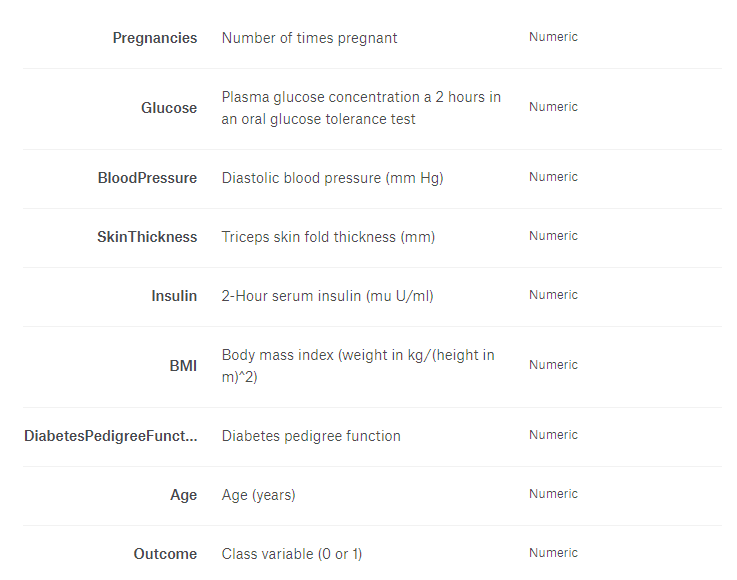

In [2]:
from IPython.display import Image
Image(filename='pima.png') 

Let's look at this ```pandas``` object in more detail:

In [3]:
# What is this thing?
print(type(data))

<class 'pandas.core.frame.DataFrame'>


In [4]:
clinical_variables = data.columns[:-1]  # all but the last (Outcome) column
print(clinical_variables)
print(len(clinical_variables))

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')
8


## Visualizing the data
A good first step (in my opinion) is to look at this data in more detail by simply plotting it. Let's use another new library called ```seaborn```, which plays very nicely with ```pandas``` to produce some pretty looking plots.

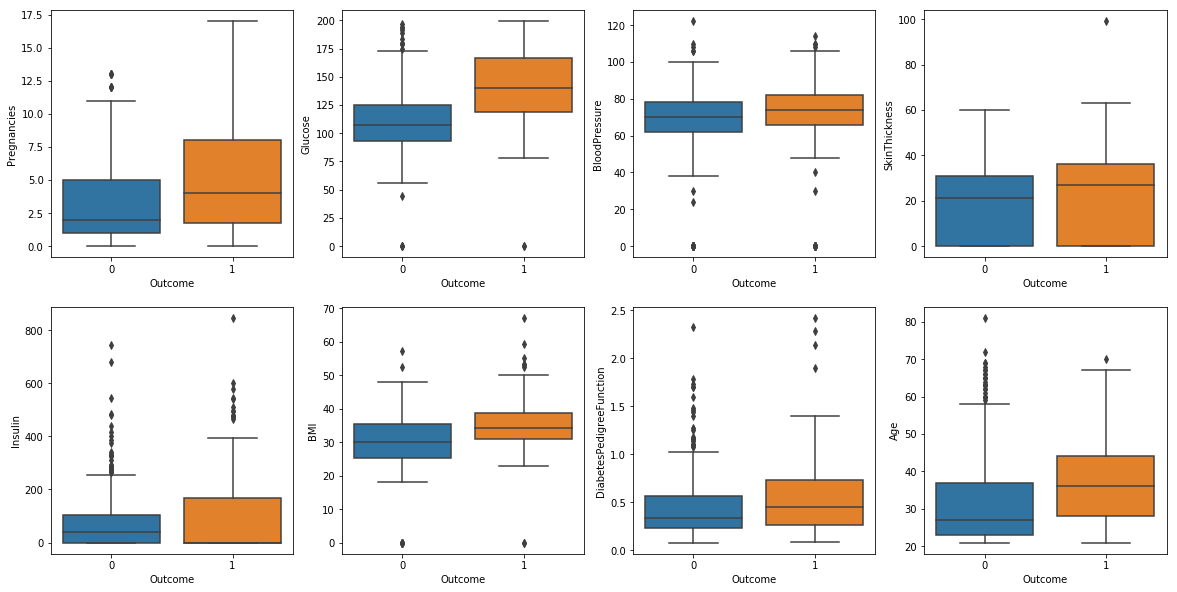

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

import seaborn as sns

for i, column in enumerate(clinical_variables):  
    
    plt.subplot(2, 4, i+1)  # total rows, total columns, position (row*column)
    box = sns.boxplot(x='Outcome', y=column, data=data)

As one might expect, there's no single variable that can serve as the sole predictor of diabetes. But perhaps some combination of these clinical variables might just work. We could exhaustively search this space... but that would take ages.

Let's see if we can train a machine learning model using  use ```scikit-learn``` to predict diabetes using all of these variables.

We have not been provided with explicit **training** and **testing** data, so let's make our own:

In [6]:
from sklearn.model_selection import train_test_split

# Note: these are not great variable names, but very common in mathematical notation
# Capital letter: matrix, lower-case letter: vector
X_train, X_test, y_train, y_test = train_test_split(data[clinical_variables], data['Outcome'], train_size=0.8, test_size=0.2)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(614, 8) (614,)
(154, 8) (154,)


## Decision trees and ensemble learning

Sounds mysterious, but is actually pretty simple and surprisingly powerful. First, what is a decision tree?

![decision](http://dataaspirant.com/wp-content/uploads/2017/01/B03905_05_01-compressor.png)

Cool, let's train one on our Pima data using ```scikit-learn```.

In [7]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

That was fast. What actually happened here? You'll need the external **graphviz** library for this: ```conda install python-graphviz```

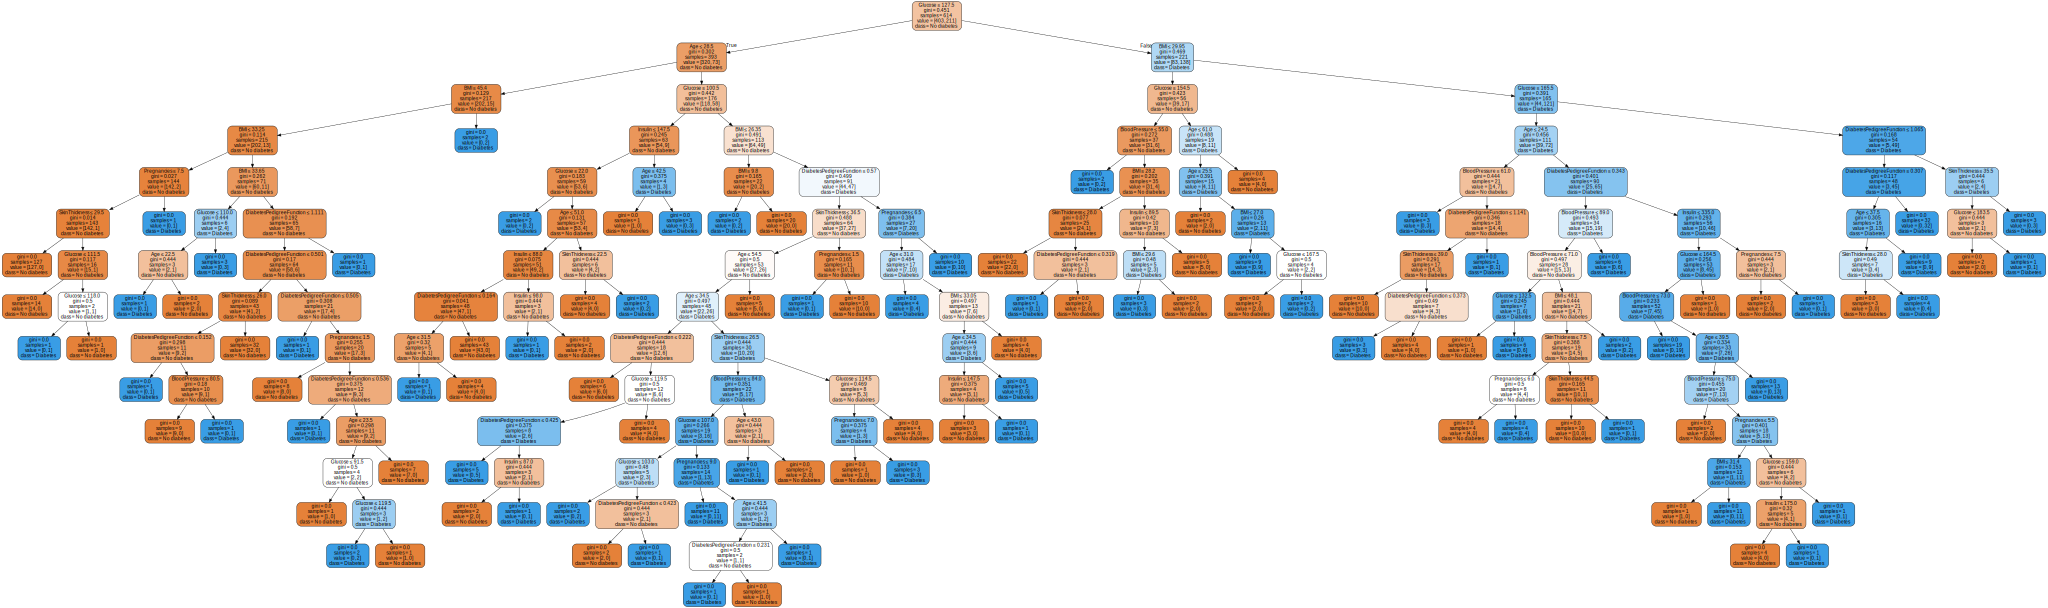

In [8]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=data.columns[:-1],  
                         class_names=['No diabetes', 'Diabetes'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

How did the model decide which features to consider? And how did it decide the cut-offs? There are several different algorithms, but all of them work by choosing variables that "best" divide the dataset into classes.

This process continues in a recursive manner until a desired depth is reached. The default method ```scikit-learn``` is called "Gini", which according to Wikipedia:

> "... a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset."

For now, let's focus on performance. How well does our decision tree perform?

In [9]:
from sklearn.metrics import accuracy_score, classification_report

# Training data
print(accuracy_score(y_train, clf.predict(X_train)))

1.0


Wow! 100% accuracy on our training data! What about our testing data?

In [10]:
# Testing...
print(accuracy_score(y_test, clf.predict(X_test)))

0.6883116883116883


Not quite so good. Herein lies the problem with decision trees - they have a tendency to  **overfit**. This is another of way of saying that our model is too complex, and any noise that might be present in the data has been given too much importance. 

![overfit](https://upload.wikimedia.org/wikipedia/commons/thumb/1/19/Overfitting.svg/300px-Overfitting.svg.png)

A random forest solves this problem by training lots of decision trees on random subsets of the data. Each tree itself might be quite poor (a so-called "weak" predictor), but as an ensemble they can be *very* powerful. 

These are equally easy to train:

In [11]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=5)  # estimators = trees. depth = how many times to split the data
rf = rf.fit(X_train, y_train)

In [12]:
print("Training accuracy: ", accuracy_score(y_train, rf.predict(X_train)))
print("Testing accuracy: ", accuracy_score(y_test, rf.predict(X_test)))

Training accuracy:  0.8583061889250815
Testing accuracy:  0.7662337662337663


Our training accuracy is lower, but that's probably because we didn't overfit (which is good). More importantly, our testing accuracy has improved! But is accuracy the best measure? How many diabetes cases do we actually have?

In [13]:
print(data["Outcome"].sum() / data.shape[0])

0.3489583333333333


Turns out that ~65% of our data are non-diabetic. If we were to guess "non-diabetic" for every case we'd be 65% accurate! 

Instead of accuracy, let's use receiver operator characteristic analysis (ROC). ROC measures the change in true positive and false positive rate, which can change depending on the threshold you use:

![roc](http://gim.unmc.edu/dxtests/roccomp.jpg)

To compute this, we need to look at the "soft" predictions of our RF classifier:

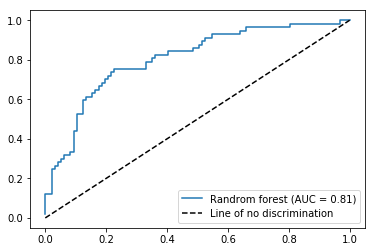

In [14]:
from sklearn.metrics import roc_curve, auc
import numpy as np
y_preda = rf.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test, y_preda[:, 1])
plt.clf()
plt.plot(fpr, tpr, label='Randrom forest (AUC = {:.2f})'.format(auc(fpr, tpr)))
plt.plot(np.linspace(0., 1.), np.linspace(0., 1.), 'k--', label='Line of no discrimination')
plt.legend()

That's actually not bad! If you're getting an area under the ROC curve (AUC) above 0.9 then you should be pretty happy. 

Let's get a better sense of how the AUC changes with different training/testing data. For this, we can use *k*-fold cross-validation.

![cv](http://api.ning.com/files/-9uTfRZAG3t1GfoSamj2MM0KoLkEgU3wAkQt5hG9o8iweunLzGyPxRnbVrGe3a8cqkMXnE4HxZGRU2nf7ojSdVuL4iM4G-kX/Capture.PNG)

In [15]:
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier()
aucs = cross_val_score(rf, data[clinical_variables], data['Outcome'], cv=5, scoring='roc_auc')

print("{} +/- {}".format(aucs.mean(), aucs.std()))

0.7943039832285115 +/- 0.03833754486960309


Our AUC is around 0.8 on average. Not bad for what amounts to only an hour's work and a few lines of Python!

### Next time

* Why random forests are a poor choice for images
* Images as tensors
* Introduction to convolutions